In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import collections

from scipy import stats
from datetime import datetime
from tqdm import tqdm
import itertools
import networkx as nx
import community
import seaborn as sns
import operator

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [ ]:
df_av = pd.read_csv('avocado-updated-2020.csv')
df_av.head()

,date,average_price,total_volume,4046,4225,4770,total_bags,small_bags,large_bags,xlarge_bags,type,year,geography
0,2015-01-04,1.22,40873.28,2819.50,28287.42,49.90,9716.46,9186.93,529.53,0.0,conventional,2015,Albany
1,2015-01-04,1.79,1373.95,57.42,153.88,0.00,1162.65,1162.65,0.00,0.0,organic,2015,Albany
2,2015-01-04,1.00,435021.49,364302.39,23821.16,82.15,46815.79,16707.15,30108.64,0.0,conventional,2015,Atlanta
3,2015-01-04,1.76,3846.69,1500.15,938.35,0.00,1408.19,1071.35,336.84,0.0,organic,2015,Atlanta
4,2015-01-04,1.08,788025.06,53987.31,552906.04,39995.03,141136.68,137146.07,3990.61,0.0,conventional,2015,Baltimore/Washington


In [ ]:
print(sorted(list(set(df_av['geography'].values))))

['Albany', 'Atlanta', 'Baltimore/Washington', 'Boise', 'Boston', 'Buffalo/Rochester', 'California', 'Charlotte', 'Chicago', 'Cincinnati/Dayton', 'Columbus', 'Dallas/Ft. Worth', 'Denver', 'Detroit', 'Grand Rapids', 'Great Lakes', 'Harrisburg/Scranton', 'Hartford/Springfield', 'Houston', 'Indianapolis', 'Jacksonville', 'Las Vegas', 'Los Angeles', 'Louisville', 'Miami/Ft. Lauderdale', 'Midsouth', 'Nashville', 'New Orleans/Mobile', 'New York', 'Northeast', 'Northern New England', 'Orlando', 'Philadelphia', 'Phoenix/Tucson', 'Pittsburgh', 'Plains', 'Portland', 'Raleigh/Greensboro', 'Richmond/Norfolk', 'Roanoke', 'Sacramento', 'San Diego', 'San Francisco', 'Seattle', 'South Carolina', 'South Central', 'Southeast', 'Spokane', 'St. Louis', 'Syracuse', 'Tampa', 'Total U.S.', 'West', 'West Tex/New Mexico']


In [ ]:
delete_list = ['Total U.S.','West','Southeast','South Central',
               'Plains','California','South Carolina',
               'Northeast','Great Lakes','Midsouth','West Tex/New Mexico']
df_av = df_av[['date','average_price','type','geography','year']]
df_av = df_av[~df_av['geography'].isin(delete_list)]
df_av.head()

,date,average_price,type,geography,year
0,2015-01-04,1.22,conventional,Albany,2015
1,2015-01-04,1.79,organic,Albany,2015
2,2015-01-04,1.00,conventional,Atlanta,2015
3,2015-01-04,1.76,organic,Atlanta,2015
4,2015-01-04,1.08,conventional,Baltimore/Washington,2015


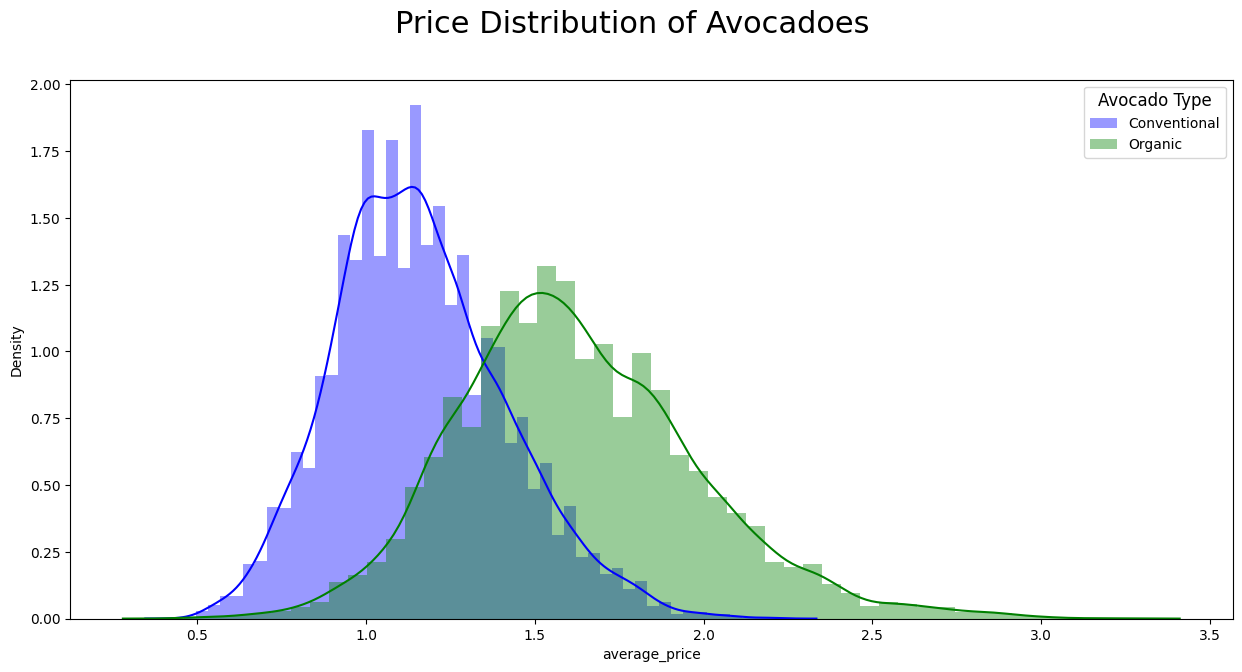

In [ ]:
fig, ax = plt.subplots(figsize=(15,7))
fig.suptitle('Price Distribution of Avocadoes', fontsize = 22)
ax1 = sns.distplot(df_av[df_av['type']=='conventional']["average_price"],
                   color = 'b',
                   label = 'Conventional')
ax2 = sns.distplot(df_av[df_av['type']=='organic']["average_price"],
                   color = 'g',
                   label = 'Organic');
plt.legend(title = 'Avocado Type', title_fontsize = 12);

In [ ]:
df_conv_pr = df_av[df_av['type']=='conventional']["average_price"]
df_orgn_pr = df_av[df_av['type']=='organic']["average_price"]

pd.DataFrame([['Mean', df_conv_pr.mean(),df_orgn_pr.mean()],
              ['Median', df_conv_pr.median(),df_orgn_pr.median()],
              ['Std', df_conv_pr.std(),df_orgn_pr.std()],
              ['Skewness', df_conv_pr.skew(),df_orgn_pr.skew()]],
              columns = ['Metric','Conventional','Organic'])

,Metric,Conventional,Organic
0,Mean,1.158571,1.622716
1,Median,1.140000,1.590000
2,Std,0.254246,0.357653
3,Skewness,0.421534,0.482697


In [ ]:
def norm_checker(df, year_thresh = 2015):
    df = df[df['year']>=year_thresh]
    final_data = []
    for r in tqdm(sorted(set(df['geography']))):
        prices_c = df.loc[(df['geography'] == r) & (df['type'] == 'conventional')]['average_price']
        prices_o = df.loc[(df['geography'] == r) & (df['type'] == 'organic')]['average_price']

        ks_statistic_c, p_value_c = stats.kstest(prices_c, 'norm')
        ks_statistic_o, p_value_o = stats.kstest(prices_o, 'norm')

        if p_value_c > 0.05:
            normal_c = 'normal'
        else:
            normal_c = 'not normal'

        if p_value_o > 0.05:
            normal_o = 'normal'
        else:
            normal_o = 'not normal'

        data = [r,ks_statistic_c,p_value_c,ks_statistic_o,p_value_o, normal_c,normal_o]
        final_data.append(data)
    return pd.DataFrame(final_data, columns = ['Region', 'Kstat_conv','p_conv','Kstat_org','p_org','result_c','result_o'])
norms  = norm_checker(df_av, 2016)
norms.head()

100%|██████████| 43/43 [00:00<00:00, 44.66it/s]


,Region,Kstat_conv,p_conv,Kstat_org,p_org,result_c,result_o
0,Albany,0.814652,1.614606e-184,0.882977,6.053063e-237,not normal,not normal
1,Atlanta,0.765499,3.249778e-156,0.815397,5.416896e-185,not normal,not normal
2,Baltimore/Washington,0.838262,2.200559e-200,0.869189,1.709560e-224,not normal,not normal
3,Boise,0.727779,1.251403e-137,0.807523,4.651697e-180,not normal,not normal
4,Boston,0.832520,2.351634e-196,0.885217,4.272308e-239,not normal,not normal


In [ ]:
def corr_creator_spearman(df, year_thresh = 2015):
    df = df[df['year']>=year_thresh]
    all_regions = sorted(set(df['geography']))
    region_combos = list(itertools.combinations(all_regions, 2))
    final_data_c = []
    final_data_o = []
    for c in tqdm(region_combos):

        df.loc[(df['geography'] == c[0]) & (df['type'] == 'organic')][['date','average_price']]
        df.loc[(df['geography'] == c[1]) & (df['type'] == 'organic')][['date','average_price']]
        merged_c = pd.merge(df.loc[(df['geography'] == c[0]) & (df['type'] == 'conventional')][['date','average_price']],
                               df.loc[(df['geography'] == c[1]) & (df['type'] == 'conventional')][['date','average_price']],
                               on='date')

        merged_o = pd.merge(df.loc[(df['geography'] == c[0]) & (df['type'] == 'organic')][['date','average_price']],
                            df.loc[(df['geography'] == c[1]) & (df['type'] == 'organic')][['date','average_price']],
                            on='date')

        spearmanr_c = stats.spearmanr(merged_c['average_price_x'],
                                      merged_c['average_price_y'])

        spearmanr_o = stats.spearmanr(merged_o['average_price_x'],
                                      merged_o['average_price_y'])


        c_data = [c[0],c[1], round(spearmanr_c[0],6),round(spearmanr_c[1],6)]
        o_data = [c[0],c[1], round(spearmanr_o[0],6),round(spearmanr_c[1],6) ]

        final_data_c.append(c_data)
        final_data_o.append(o_data)

    df_c = pd.DataFrame(final_data_c, columns = ['region_1','region_2','spearman_corr','significance'])
    df_o = pd.DataFrame(final_data_o, columns = ['region_1','region_2','spearman_corr','significance'])
    return [df_c,df_o]

df_spear = corr_creator_spearman(df_av, 2016)
df_spear

100%|██████████| 903/903 [00:48<00:00, 18.59it/s]


[      region_1              region_2  spearman_corr  significance
 0       Albany               Atlanta       0.486023      0.000000
 1       Albany  Baltimore/Washington       0.545374      0.000000
 2       Albany                 Boise       0.285943      0.000004
 3       Albany                Boston       0.524562      0.000000
 4       Albany     Buffalo/Rochester       0.568242      0.000000
 ..         ...                   ...            ...           ...
 898    Spokane              Syracuse       0.085856      0.172538
 899    Spokane                 Tampa       0.379024      0.000000
 900  St. Louis              Syracuse       0.417666      0.000000
 901  St. Louis                 Tampa       0.676333      0.000000
 902   Syracuse                 Tampa       0.576585      0.000000
 
 [903 rows x 4 columns],
       region_1              region_2  spearman_corr  significance
 0       Albany               Atlanta       0.074480      0.000000
 1       Albany  Baltimore/Washingt

In [ ]:
def construct_network_spear(df, signthresh = 0.05, corrthresh = 0.50):
    av_G = nx.Graph()
    for i in tqdm(df.iterrows()):
        if i[1][3] <= signthresh:
            av_G.add_edge(i[1][0], i[1][1], weight = i[1][2])
        else:
            av_G.add_node(i[1][0])
            av_G.add_node(i[1][1])

    av_G.remove_edges_from(nx.selfloop_edges(av_G))
    low_weight_edges = [i[:2]  for i in av_G.edges(data=True) if abs(i[2]['weight']) <= corrthresh]
    av_G.remove_edges_from(low_weight_edges)

    return av_G

def get_network_metrics(df):

    thresh_list = np.arange(0.1,1,0.05)
    list_of_graphs = [construct_network_spear(df, 0.05, thresh) for thresh in thresh_list]

    final_list = []
    for n, g in enumerate(list_of_graphs):
        GC_nodes = max(nx.connected_components(g), key=len)
        GC = g.subgraph(GC_nodes).copy()
        SC = [g.subgraph(i).copy() for i in
              list(nx.connected_components(g)) if i != GC_nodes]
        L = g.size()
        avg_deg = float(L) / g.order()

        #Try/Except logic as the function will error if SC == 0
        try:
            SC_average_nodes = np.mean([len(i) for i in SC])
            SC_max_nodes = np.max([len(i) for i in SC])
            SC_min_nodes = np.min([len(i) for i in SC])
        except:
            SC_average_nodes = np.nan
            SC_max_nodes = np.nan
            SC_min_nodes = np.nan

        data_point = (L, avg_deg, len(GC), len(SC),
                      SC_average_nodes, SC_max_nodes, SC_min_nodes, thresh_list[n])
        final_list.append(data_point)
    return pd.DataFrame(final_list,
                        columns =  ['Size','Ave Degree',
                                    '# of Nodes in GC','# of SC', 'Mean of SCs',
                                    'Max of SCs', 'Min of SCs', 'Corr Thresh'])

df_spear_c_metrics = get_network_metrics(df_spear[0])
df_spear_o_metrics = get_network_metrics(df_spear[1])

903it [00:00, 16524.17it/s]
903it [00:00, 19633.49it/s]
903it [00:00, 17172.00it/s]
903it [00:00, 17909.63it/s]
903it [00:00, 16504.01it/s]
903it [00:00, 18595.41it/s]
903it [00:00, 19103.19it/s]
903it [00:00, 18717.91it/s]
903it [00:00, 18405.37it/s]
903it [00:00, 17270.35it/s]
903it [00:00, 16998.52it/s]
903it [00:00, 18755.91it/s]
903it [00:00, 19894.30it/s]
903it [00:00, 19129.92it/s]
903it [00:00, 16101.63it/s]
903it [00:00, 20391.17it/s]
903it [00:00, 16430.27it/s]
903it [00:00, 19513.52it/s]
903it [00:00, 19053.32it/s]
903it [00:00, 15585.79it/s]
903it [00:00, 18252.63it/s]
903it [00:00, 19713.19it/s]
903it [00:00, 18436.19it/s]
903it [00:00, 19565.33it/s]
903it [00:00, 19271.74it/s]
903it [00:00, 19241.49it/s]
903it [00:00, 19133.59it/s]
903it [00:00, 19578.07it/s]
903it [00:00, 19772.68it/s]
903it [00:00, 19068.47it/s]
903it [00:00, 17830.04it/s]
903it [00:00, 18196.85it/s]
903it [00:00, 17254.30it/s]
903it [00:00, 19179.52it/s]
903it [00:00, 19622.50it/s]
903it [00:00, 18470.

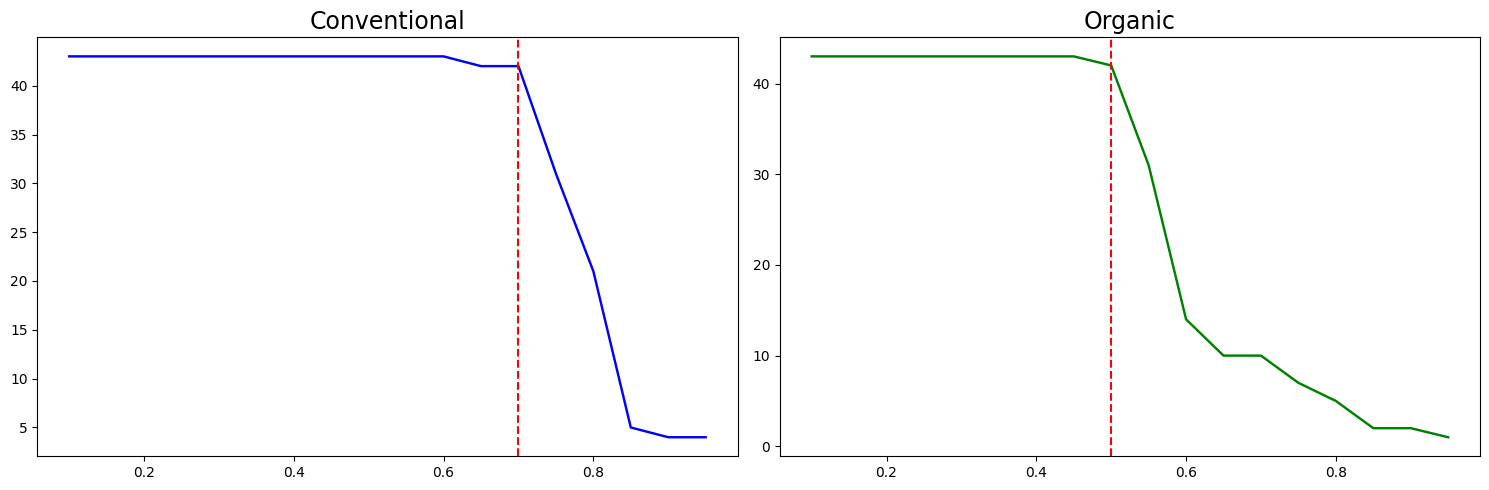

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(15,5))
ax[0].set_title('Conventional', fontsize = 17)
ax[0].plot(df_spear_c_metrics['Corr Thresh'],
           df_spear_c_metrics['# of Nodes in GC'],
           color = 'blue', linewidth = 1.75)
ax[0].axvline(x=0.70, color='r', linestyle='--')

ax[1].set_title('Organic', fontsize = 17)
ax[1].plot(df_spear_o_metrics['Corr Thresh'],
           df_spear_o_metrics['# of Nodes in GC'],
           color = 'green', linewidth = 1.75)
ax[1].axvline(x=0.50, color='r', linestyle='--')
fig.tight_layout();

In [ ]:
df_spear_o_metrics

,Size,Ave Degree,# of Nodes in GC,# of SC,Mean of SCs,Max of SCs,Min of SCs,Corr Thresh
0,715,16.627907,43,0,NaN,NaN,NaN,0.10
1,628,14.604651,43,0,NaN,NaN,NaN,0.15
2,544,12.651163,43,0,NaN,NaN,NaN,0.20
3,467,10.860465,43,0,NaN,NaN,NaN,0.25
4,377,8.767442,43,0,NaN,NaN,NaN,0.30
5,303,7.046512,43,0,NaN,NaN,NaN,0.35
6,244,5.674419,43,0,NaN,NaN,NaN,0.40
7,193,4.488372,43,0,NaN,NaN,NaN,0.45
8,150,3.488372,42,1,1.000000,1.0,1.0,0.50
9,109,2.534884,31,3,4.000000,9.0,1.0,0.55


In [ ]:
spear_c_network = construct_network_spear(df_spear[0], 0.05, 0.70)
spear_o_network = construct_network_spear(df_spear[1], 0.05, 0.50)

def plot_single_network(network, title):
    plt.figure(figsize=(15,7))

    g_corr = network.subgraph(sorted(nx.connected_components(network), key = len, reverse = True)[0])
    d = dict(network.degree)
    d_g = dict(g_corr.degree)
    plt.suptitle(title, fontsize=20, y=0.95)
    pos = nx.spring_layout(network, seed = 45);
    nx.draw_networkx_nodes(network , pos, cmap=plt.cm.RdYlBu_r,
                           node_color = [val for (node, val) in network.degree()],
                           node_size=[v * 25 for v in d.values()]);
    nx.draw_networkx_edges(network , pos, width=0.75, alpha=0.45,
                            edge_color="grey");
    nx.draw_networkx_labels(network, pos, font_color  = 'grey')
    plt.show();

    plt.figure(figsize=(15,7))
    plt.suptitle(f'{title} Giant Component', fontsize=20, y=0.95)
    pos = nx.spring_layout(g_corr, seed = 45);
    nx.draw_networkx_nodes(g_corr , pos, cmap=plt.cm.RdYlBu_r,
                           node_color = [val for (node, val) in g_corr.degree()],
                           node_size=[v * 25 for v in d_g.values()]);
    nx.draw_networkx_edges(g_corr , pos, width=0.75, alpha=0.45,
                            edge_color="grey");
    nx.draw_networkx_labels(g_corr, pos, font_color  = 'grey')

    plt.show();

def degree_dist(network1, network2):
    degrees1 = [d for n,d in network1.degree()]
    degrees2 = [d for n,d in network2.degree()]

    fig, ax = plt.subplots(figsize=(15,7))
    fig.suptitle('Degree Distribution of Networks', fontsize = 22)
    ax1 = sns.histplot(degrees1, edgecolor='white', linewidth=0.75,
                       color = 'b', kde = False, binwidth=1,alpha = 0.55,
                       label = 'Conventional')
    ax2 = sns.histplot(degrees2, edgecolor='white', linewidth=0.75,
                       color = 'g', kde = False, binwidth=1,alpha = 0.55,
                       label = 'Organic');
    plt.legend(title = 'Degree Distribution', title_fontsize = 12);

903it [00:00, 19419.77it/s]
903it [00:00, 19450.08it/s]


In [ ]:
def plot_single_network(network, title):
    fig, ax = plt.subplots(1,2, figsize=(20,7))

    g_corr = network.subgraph(sorted(nx.connected_components(network), key = len, reverse = True)[0])
    d = dict(network.degree)
    d_g = dict(g_corr.degree)
    ax[0].set_title(title, fontsize=20, y=1.0)
    pos = nx.spring_layout(network, seed = 45)
    nx.draw_networkx_nodes(network , pos, cmap=plt.cm.RdYlBu_r,
                           node_color = [val for (node, val) in network.degree()],
                           node_size=[v * 25 for v in d.values()],
                           ax = ax[0]);
    nx.draw_networkx_edges(network , pos, width=0.75, alpha=0.45,
                            edge_color="grey", ax = ax[0]);
    nx.draw_networkx_labels(network, pos, font_color  = 'grey',
                            ax = ax[0])

    ax[1].set_title(f'{title} Giant Component', fontsize=20, y=1.0)
    pos = nx.spring_layout(g_corr, seed = 45);
    nx.draw_networkx_nodes(g_corr , pos, cmap=plt.cm.RdYlBu_r,
                           node_color = [val for (node, val) in g_corr.degree()],
                           node_size=[v * 25 for v in d_g.values()],
                           ax = ax[1]);
    nx.draw_networkx_edges(g_corr , pos, width=0.75, alpha=0.45,
                            edge_color="grey",ax = ax[1]);
    nx.draw_networkx_labels(g_corr, pos, font_color  = 'grey',
                            ax = ax[1])

    fig.tight_layout();

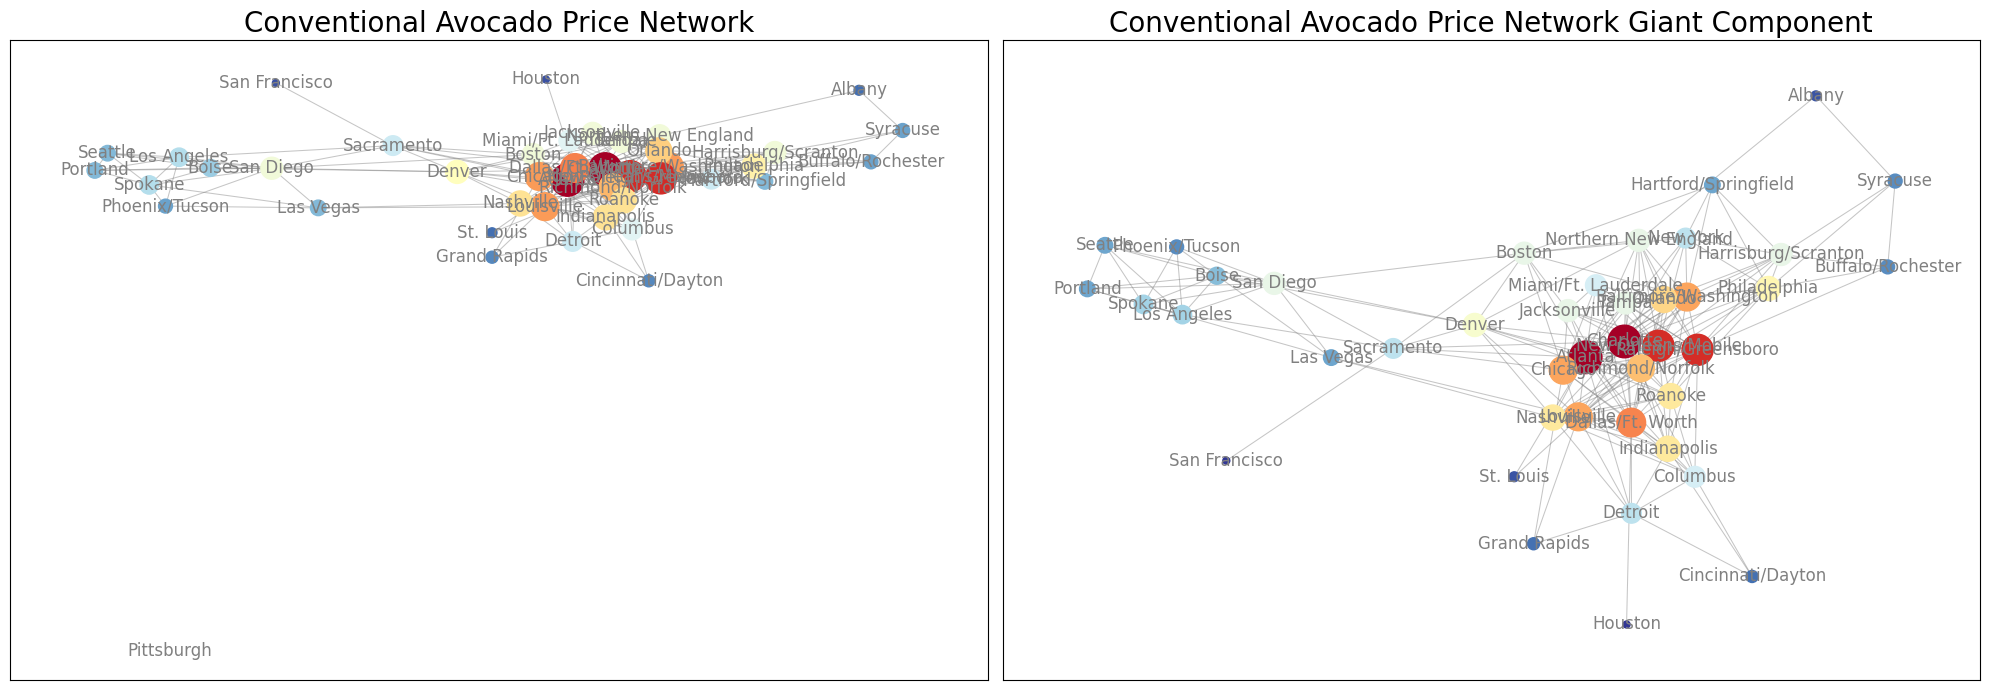

In [ ]:
plot_single_network(spear_c_network, 'Conventional Avocado Price Network')

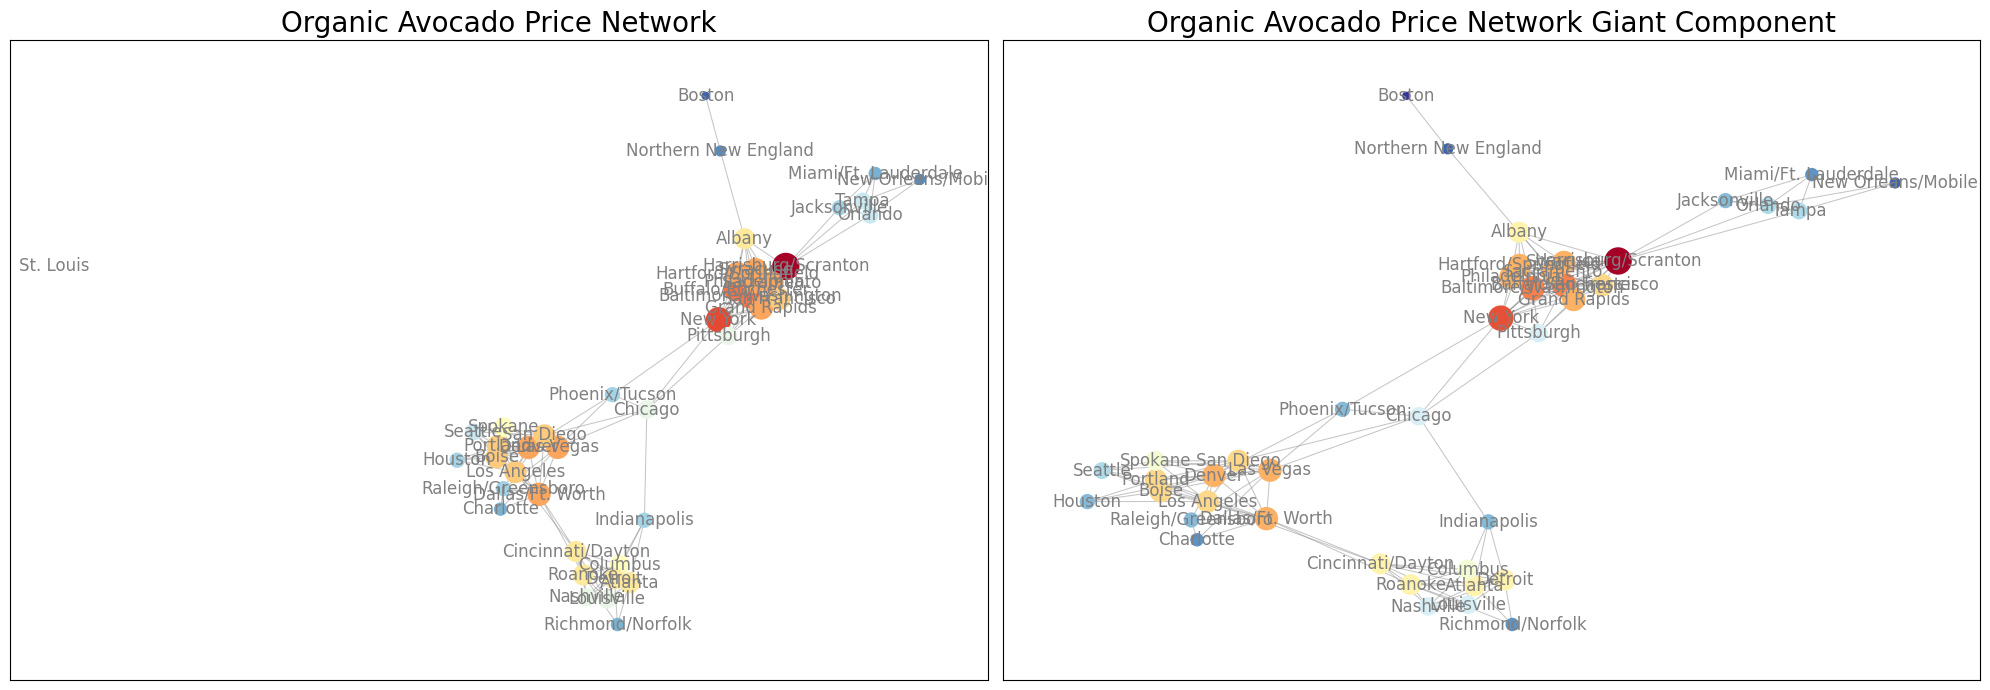

In [ ]:
plot_single_network(spear_o_network, 'Organic Avocado Price Network')

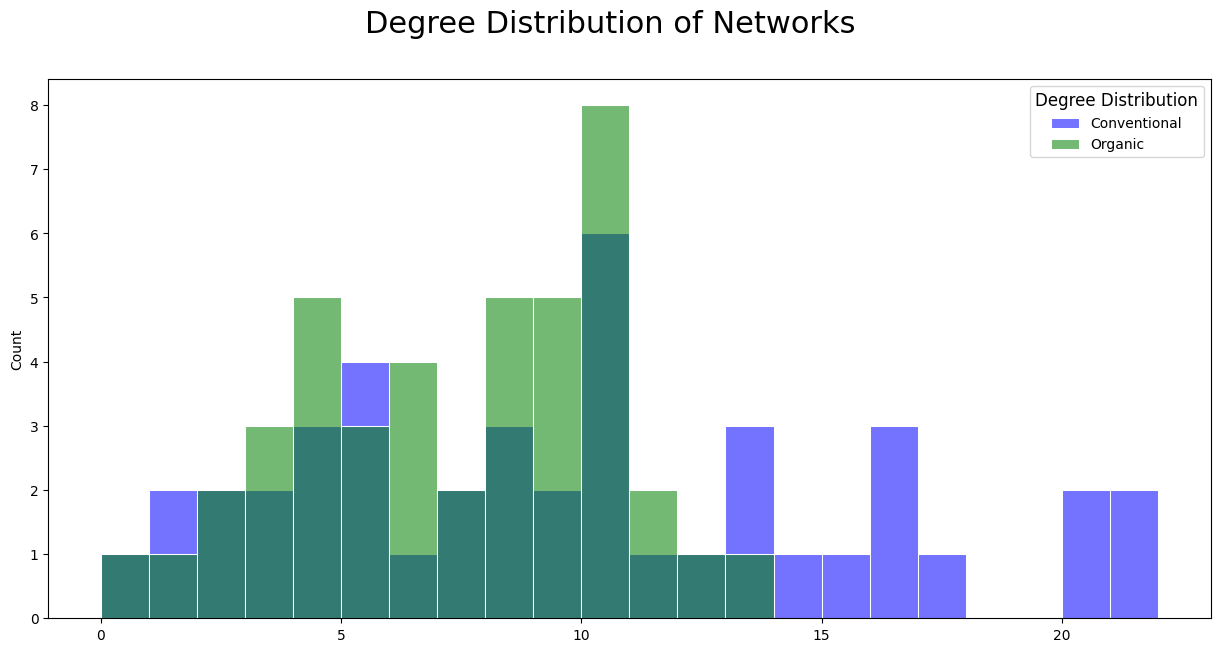

In [ ]:
degree_dist(spear_c_network,spear_o_network)

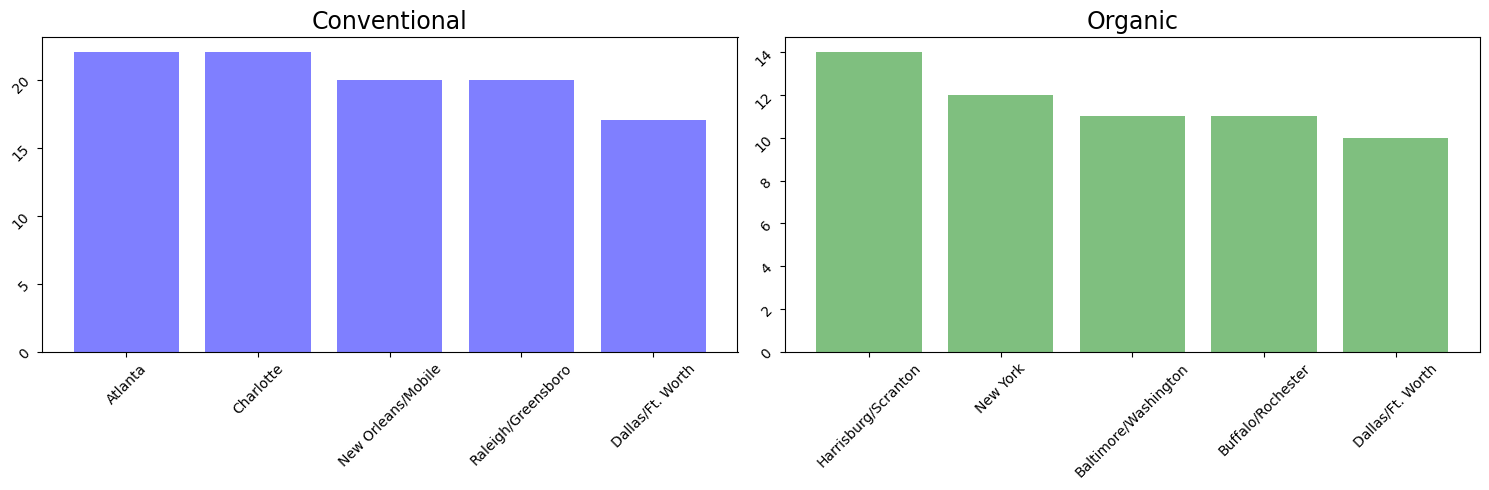

In [ ]:
deg_c = sorted([(n,d) for n,d in spear_c_network.degree()], key = lambda x:(-x[1], x[0]))[:5]
deg_o = sorted([(n,d) for n,d in spear_o_network.degree()], key = lambda x:(-x[1], x[0]))[:5]

### Plot the distribution
fig, ax = plt.subplots(1,2,figsize=(15,5))
ax[0].set_title('Conventional', fontsize = 17)
ax[0].bar(range(len(deg_c)),
          [val[1] for val in deg_c],
          color = 'blue',
          alpha = 0.50,
          align='center')
ax[0].set_xticks(range(len(deg_c)))
ax[0].set_xticklabels([val[0] for val in deg_c])
ax[0].tick_params(rotation=45)

ax[1].set_title('Organic', fontsize = 17)
ax[1].bar(range(len(deg_o)),
          [val[1] for val in deg_o],
          color = 'green',
          alpha = 0.50,
          align='center')
ax[1].set_xticks(range(len(deg_o)))
ax[1].set_xticklabels([val[0] for val in deg_o])
ax[1].tick_params(rotation=45)

fig.tight_layout()

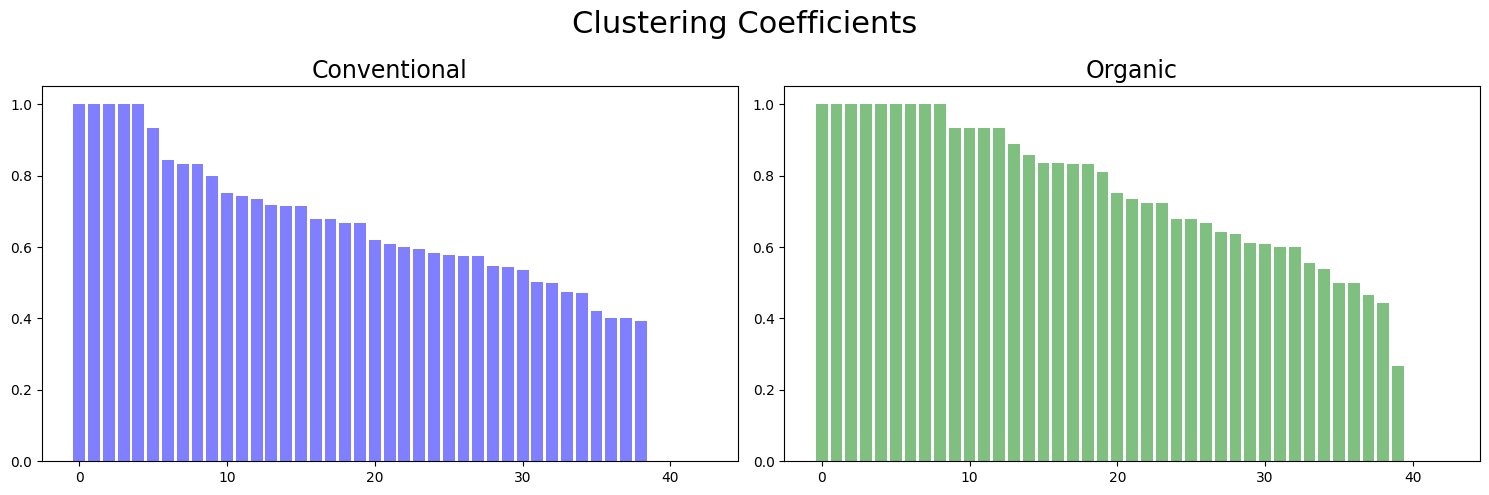

In [ ]:
cc_c = sorted(nx.clustering(spear_c_network).items(), key = lambda x:(-x[1],x[0]))
cc_o = sorted(nx.clustering(spear_o_network).items(), key = lambda x:(-x[1],x[0]))

### Plot the distribution
fig, ax = plt.subplots(1,2,figsize=(15,5))
fig.suptitle('Clustering Coefficients', fontsize=22)
ax[0].set_title('Conventional', fontsize = 17)
ax[0].bar(range(len(cc_c)),
          [val[1] for val in cc_c],
          color = 'blue',
          alpha = 0.50,
          align='center')

ax[1].set_title('Organic', fontsize = 17)
ax[1].bar(range(len(cc_o)),
          [val[1] for val in cc_o],
          color = 'green',
          alpha = 0.50,
          align='center')

fig.tight_layout();

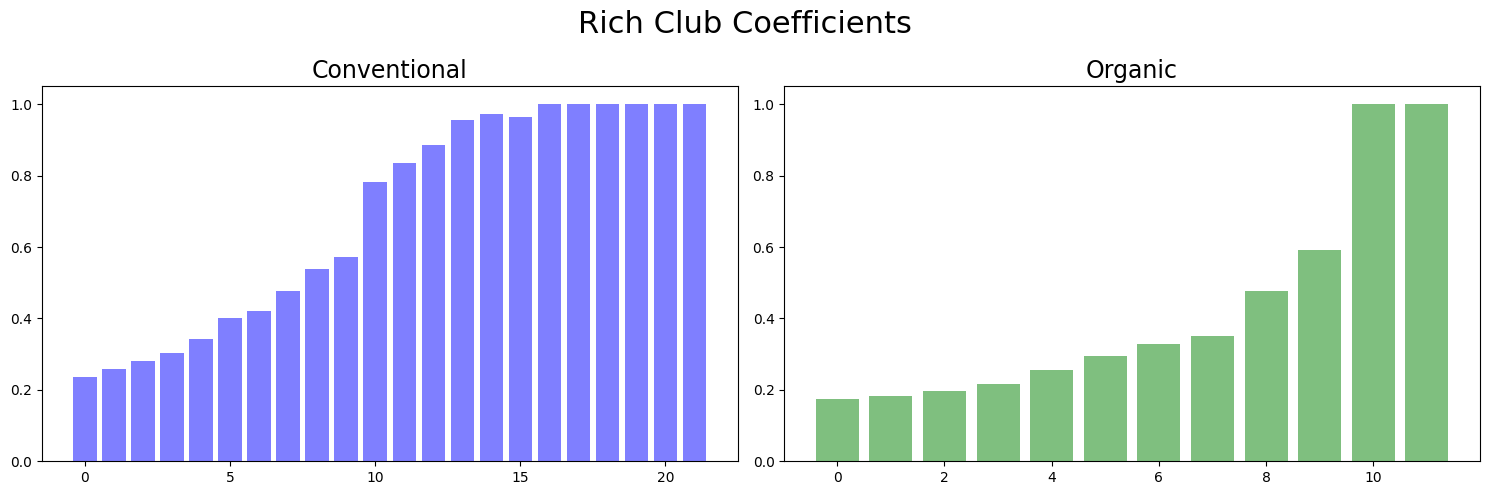

In [ ]:
rc_c = nx.rich_club_coefficient(spear_c_network, normalized=False, seed=42)
rc_o = nx.rich_club_coefficient(spear_o_network, normalized=False, seed=42)

### Plot the distribution
fig, ax = plt.subplots(1,2,figsize=(15,5))
fig.suptitle('Rich Club Coefficients', fontsize=22)
ax[0].set_title('Conventional', fontsize = 17)
ax[0].bar(rc_c.keys(),
          rc_c.values(),
          color = 'blue',
          alpha = 0.50,
          align='center')

ax[1].set_title('Organic', fontsize = 17)
ax[1].bar(rc_o.keys(),
          rc_o.values(),
          color = 'green',
          alpha = 0.50,
          align='center')

fig.tight_layout();

In [ ]:
def centrality_plotter(network, title):
    g_corr = network.subgraph(sorted(nx.connected_components(network), key = len, reverse = True)[0])
    fig, ax = plt.subplots(2,2, figsize=(20,15))

    centralities = [list(nx.degree_centrality(g_corr).values()),
                    list(nx.closeness_centrality(g_corr).values()),
                    list(nx.betweenness_centrality(g_corr).values()),
                    list(nx.eigenvector_centrality(g_corr).values())]
    titles = ['Degree Centrality', 'Closeness Centrality',
              'Betweenness Centrality', 'Eigenvector Centrality']
    fig.suptitle(title, fontsize=25)
    for n, ax in enumerate(ax.flatten()):
        ax.set_title(titles[n], fontsize = 19);
        pos = nx.spring_layout(g_corr, seed = 45)

        nc = nx.draw_networkx_nodes(g_corr, pos, node_size=300, cmap=plt.cm.RdYlBu_r,
                                    node_color=centralities[n], ax = ax);


        nx.draw_networkx_edges(g_corr, pos, alpha=0.40, ax = ax);
        nx.draw_networkx_labels(g_corr, pos, font_color='grey', ax = ax);
        ax.set_axis_off()
        plt.colorbar(nc, ax = ax);

    fig.tight_layout()
    fig.subplots_adjust(top=0.90);

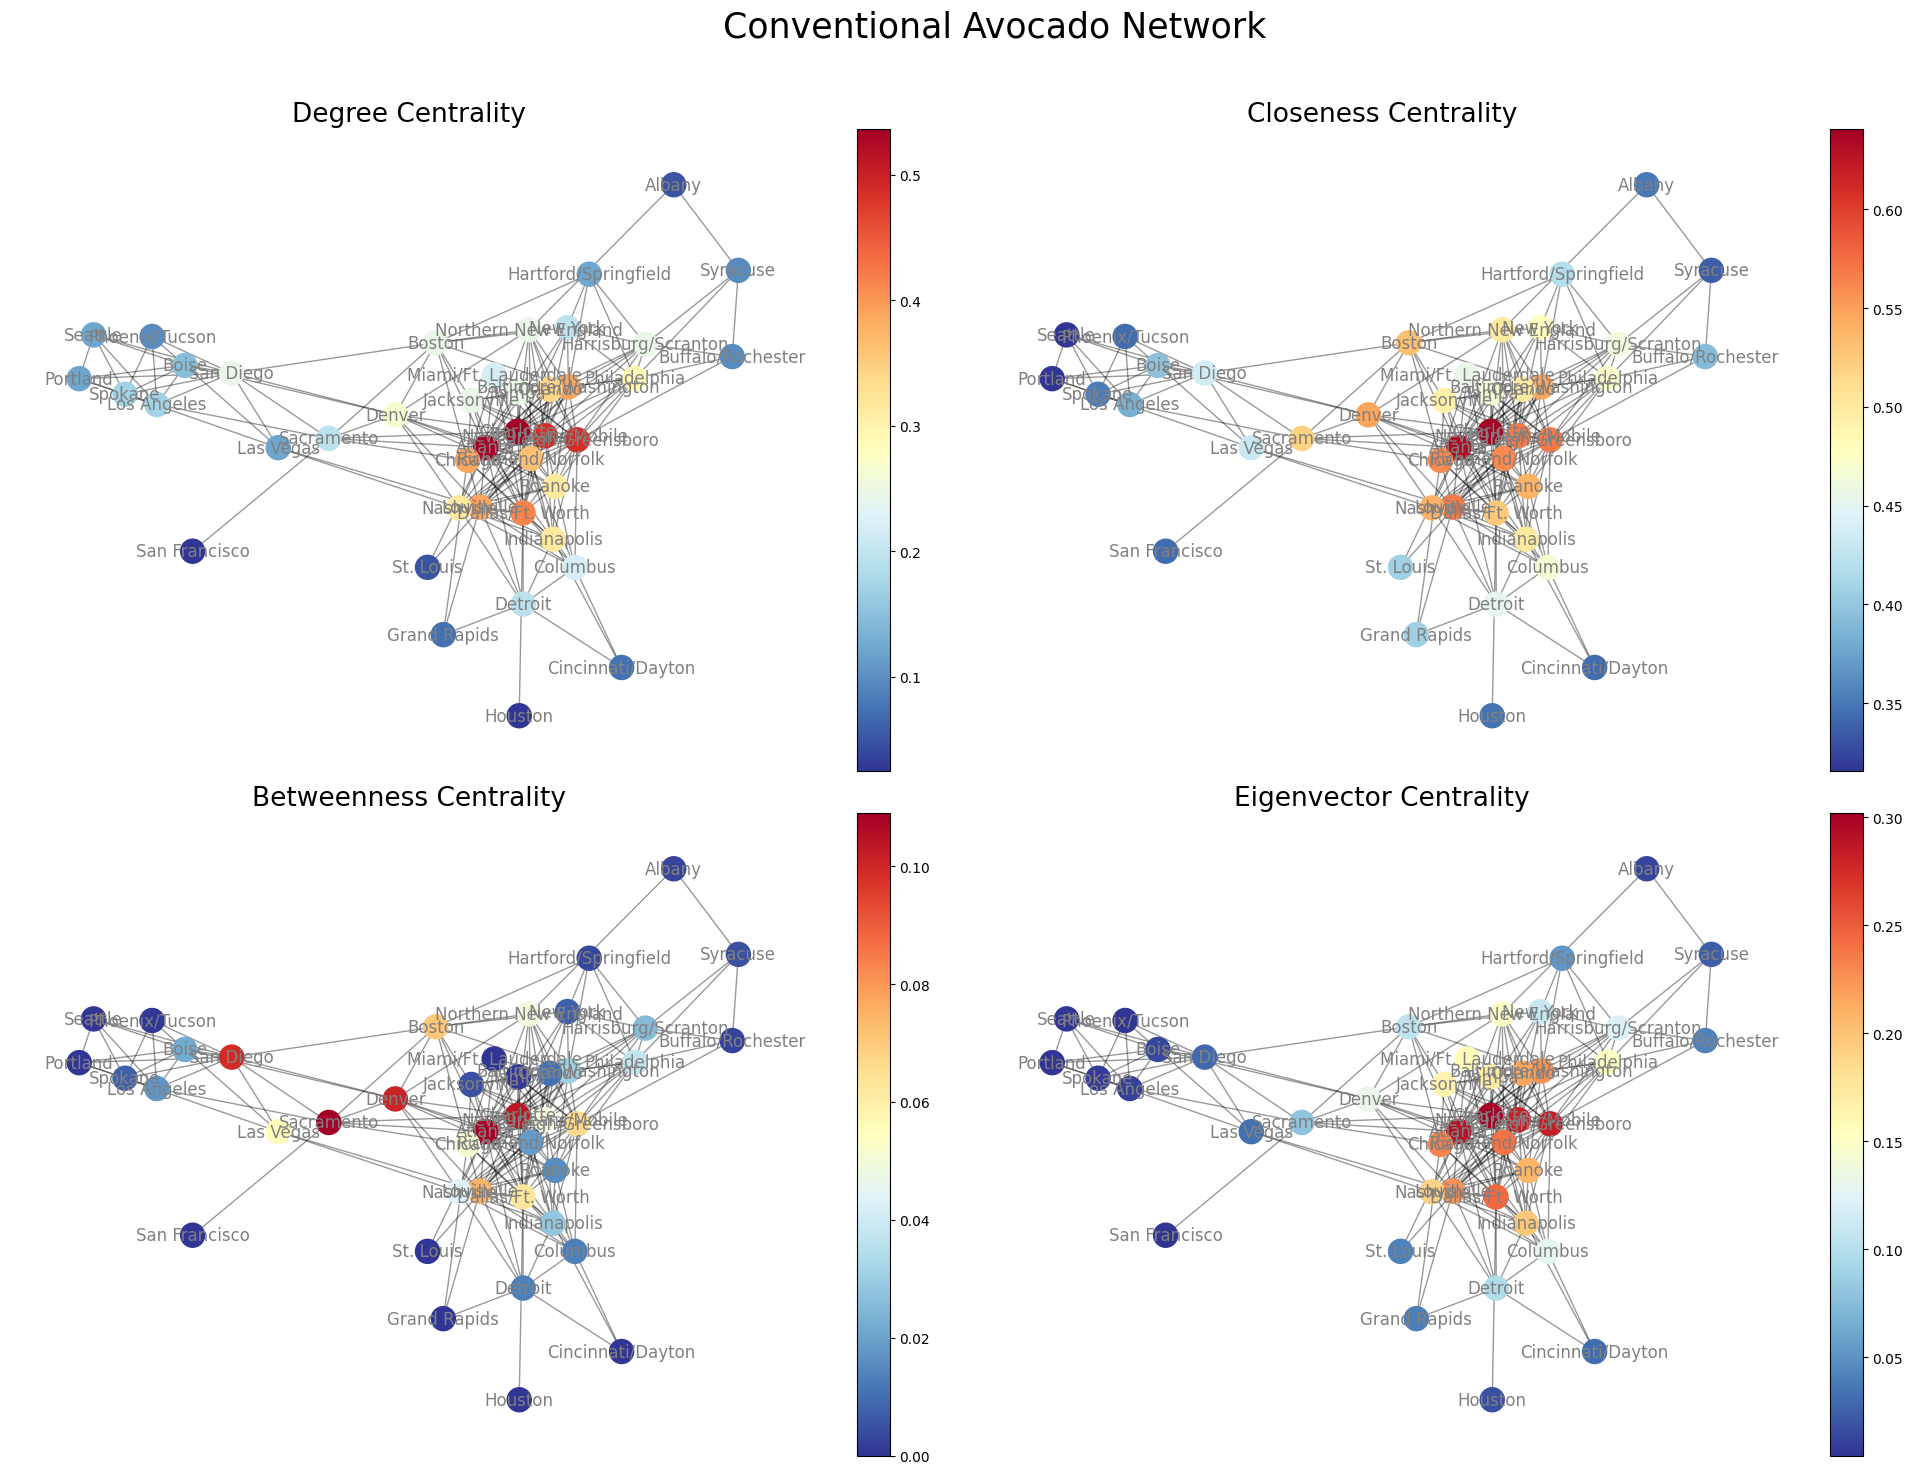

In [ ]:
centrality_plotter(spear_c_network, 'Conventional Avocado Network')

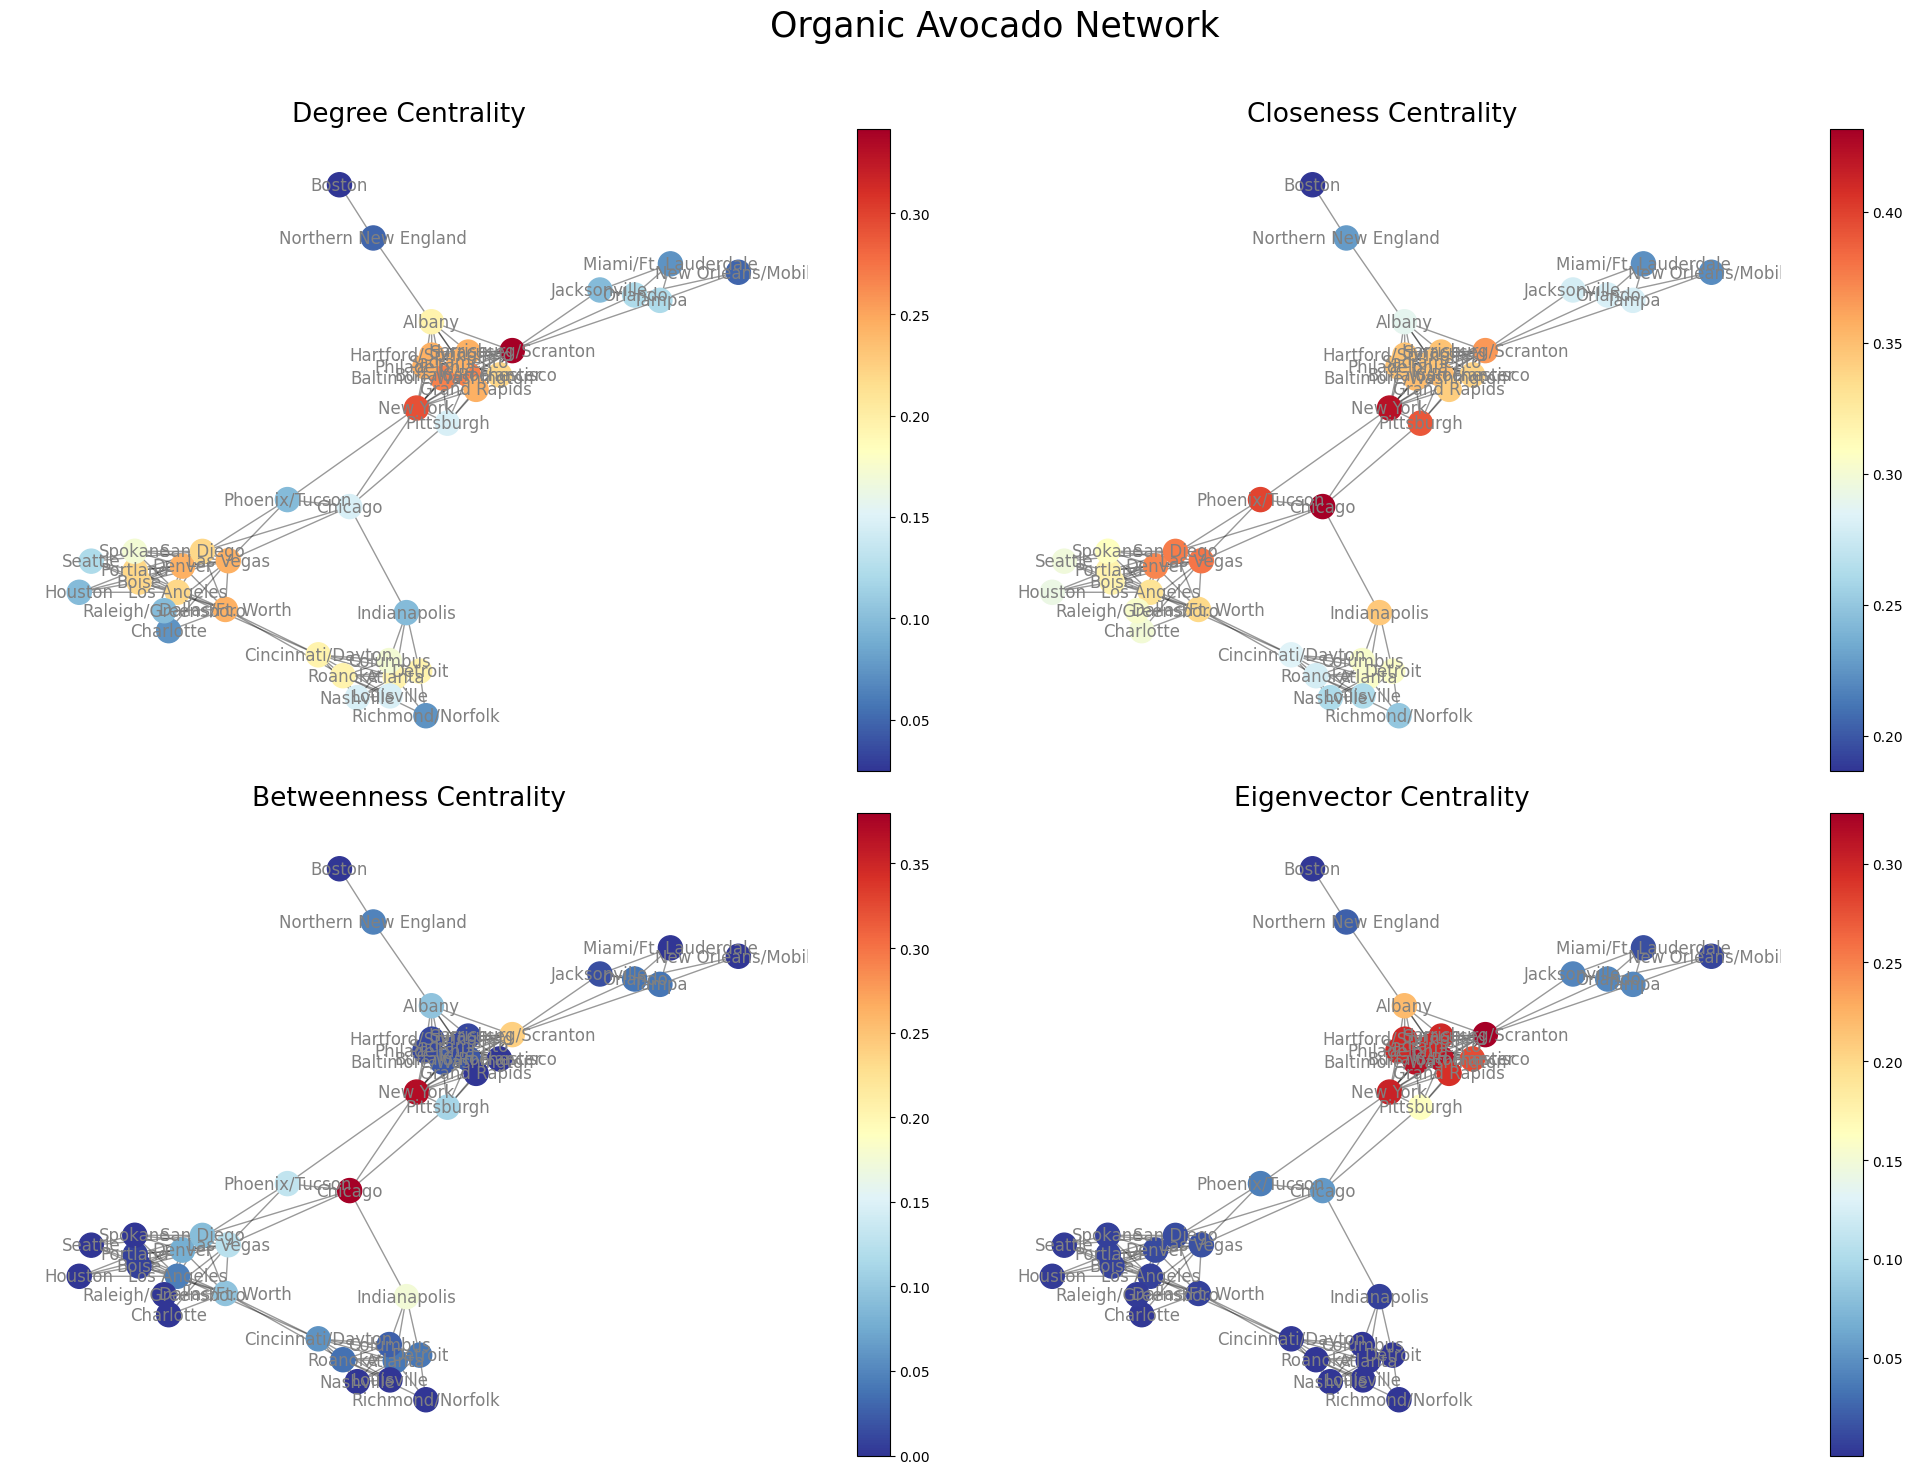

In [ ]:
centrality_plotter(spear_o_network,'Organic Avocado Network')

In [ ]:
def community_plotter(network1, network2): #Louvian Method
    titles = ['Conventional Communities','Organic Communities']
    g_corr_1 = network1.subgraph(sorted(nx.connected_components(network1), key = len, reverse = True)[0])
    g_corr_2 = network2.subgraph(sorted(nx.connected_components(network2), key = len, reverse = True)[0])

    partition_1 = community.best_partition(g_corr_1, random_state = 42)
    partition_2 = community.best_partition(g_corr_2, random_state = 42)

    identifier = [list(partition_1.values()),
                  list(partition_2.values())]

    graphs = [g_corr_1,g_corr_2]

    fig, ax = plt.subplots(1,2, figsize=(15,7))
    for n, ax in enumerate(ax.flatten()):
        ax.set_title(titles[n], fontsize = 17);
        pos = nx.spring_layout(graphs[n], seed = 45)

        nc = nx.draw_networkx_nodes(graphs[n], pos, node_size=300, cmap=plt.cm.RdYlBu_r,
                                    node_color=identifier[n], ax = ax);

        nx.draw_networkx_edges(graphs[n], pos, alpha=0.40, ax = ax);
        nx.draw_networkx_labels(graphs[n], pos, font_color='grey', font_size = 9.5, ax = ax);

    fig.tight_layout();

In [ ]:
import networkx as nx
import community as community_louvain
import matplotlib.pyplot as plt

def community_plotter(network1, network2):
    titles = ['Conventional Communities', 'Organic Communities']
    g_corr_1 = network1.subgraph(
        sorted(nx.connected_components(network1), key=len, reverse=True)[0]
    )
    g_corr_2 = network2.subgraph(
        sorted(nx.connected_components(network2), key=len, reverse=True)[0]
    )

    partition_1 = community_louvain.best_partition(g_corr_1, random_state=42)
    partition_2 = community_louvain.best_partition(g_corr_2, random_state=42)

    identifier = [list(partition_1.values()), list(partition_2.values())]

    graphs = [g_corr_1, g_corr_2]

    fig, ax = plt.subplots(1, 2, figsize=(15, 7))
    for n, axes in enumerate(ax.flatten()):
        axes.set_title(titles[n], fontsize=17)
        pos = nx.spring_layout(graphs[n], seed=45)

        nc = nx.draw_networkx_nodes(
            graphs[n],
            pos,
            node_size=300,
            cmap=plt.cm.RdYlBu_r,
            node_color=identifier[n],
            ax=axes,
        )

        nx.draw_networkx_edges(graphs[n], pos, alpha=0.40, ax=axes)
        nx.draw_networkx_labels(graphs[n], pos, font_color='grey', font_size=9.5, ax=axes)

    fig.tight_layout()
    plt.show()



In [ ]:
!pip install python-louvain==0.15

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
community_plotter(spear_c_network, spear_o_network)

AttributeError: ignored

In [ ]:
g_corr_c = spear_c_network.subgraph(sorted(nx.connected_components(spear_c_network), key = len, reverse = True)[0])
g_corr_o = spear_o_network.subgraph(sorted(nx.connected_components(spear_o_network), key = len, reverse = True)[0])

partition_c = community.best_partition(g_corr_c, random_state = 42)
partition_o = community.best_partition(g_corr_o, random_state = 42)

fig, ax = plt.subplots(1,2, figsize=(15,5))
sns.countplot(x = 0, data = pd.DataFrame(partition_c, index = [0]).T.reset_index(),
              ax = ax[0], palette =['#000fff', '#00D1FF','#Ffa700', '#Ff1f00'] ).set_title("Count of Conventional Community Memebers", fontsize = 15);
sns.countplot(x = 0, data = pd.DataFrame(partition_o, index = [0]).T.reset_index(),
              ax = ax[1], palette =['#000fff', '#00D1FF','#f2ff00', '#ff8400','#Ff2900']).set_title("Count of Organic Community Memebers", fontsize = 15);
ax[0].set(xlabel=None)
ax[1].set(xlabel=None)

fig.tight_layout();

AttributeError: ignored